
**Introduction**

La classification des textes est une tâche importante en traitement automatique du langage naturel (TALN), visant à catégoriser des textes en fonction de leur contenu. Dans ce projet, nous explorons différentes approches pour classer les critiques de films en français selon leur tonalité, positive ou négative. Nous commençons par définir un pipeline de prétraitement des textes, puis nous réalisons un baseline en utilisant des méthodes simples telles que bag-of-words et TF-IDF avec deux algorithmes de classification. suivi par l'utilisation de LSTM pour la classification. Nous évaluons ensuite la performance des différents modèles en nous basant sur les matrices de confusion et analysons certaines des erreurs pour en tirer des explications.

**Contexte**

Ce projet s'inscrit dans le cadre du module M33 Deep Learning II, où nous explorons les méthodes d'apprentissage profond pour des tâches de traitement du langage naturel. Nous utilisons un ensemble de données composé de critiques de films en langue française, collectées à partir du site allocine.fr sur une période allant de 2006 à 2020. Cet ensemble de données a été préparé par Théophile Blard et est disponible dans la bibliothèque huggingface.

**Données**

L'ensemble de données se compose de 100 000 critiques positives et 100 000 critiques négatives, réparties en ensembles d'entraînement (160 000), de validation (20 000) et de test (20 000). Chaque critique est accompagnée de sa polarité correspondante (0 pour négative, 1 pour positive). Ces données constituent une ressource précieuse pour l'entraînement et l'évaluation de notre modèle de classification.

**Pipeline de Prétraitement des Textes**

Dans notre pipeline de prétraitement des textes, nous appliquons les règles classiques de nettoyage et de normalisation, telles que la suppression des caractères spéciaux, la mise en minuscule, la lemmatisation, et la suppression des mots vides (stopwords). Nous pouvons également considérer des techniques plus avancées telles que la correction orthographique et la détection de la négation pour améliorer la qualité des données.

**Baseline avec Méthodes Simples**

Nous commençons par créer un baseline en utilisant des méthodes simples comme bag-of-words et TF-IDF, avec deux algorithmes de classification populaires tels que la régression logistique et les arbres de décision. Cela nous donne une référence pour évaluer les performances des modèles plus complexes.

**Encodage avec Word2Vec**

Ensuite, nous exploitons un modèle word2vec préentraîné pour encoder les textes en représentations vectorielles continues. Ces embeddings captureront la sémantique des mots dans les critiques de films, ce qui permettra à notre modèle de capturer des informations plus riches et subtiles.

**Utilisation de LSTM pour la Classification**

Nous utilisons ensuite des réseaux de neurones récurrents (LSTM) pour la classification des textes. En expérimentant avec différentes architectures LSTM et optimiseurs, nous cherchons à maximiser la précision de notre modèle. Nous comparons également les performances des LSTM avec celles des méthodes basées sur bag-of-words et TF-IDF.

**Évaluation des Performances**

Nous évaluons la performance de nos différents modèles en utilisant des matrices de confusion, qui nous donnent un aperçu de la précision, du rappel et de la F-mesure pour chaque classe de sentiment (positive et négative). Cela nous permet de déterminer quel modèle est le plus efficace pour la classification des critiques de films en français.

**Analyse des Erreurs**

Enfin, nous analysons certaines des erreurs commises par nos modèles pour comprendre les faiblesses et les limites de chaque approche. Nous examinons les exemples mal classés et essayons de trouver des explications, ce qui nous aidera à identifier les domaines où nos modèles peuvent être améliorés.

### I) Chargement des données

In [3]:
import warnings
# Ignorer tous les avertissements
warnings.filterwarnings("ignore")
# Ignorer un type spécifique d'avertissement, par exemple DeprecationWarning
warnings.filterwarnings("ignore", category=DeprecationWarning)
# Ignorer tous les avertissements pour le reste du script
warnings.filterwarnings("ignore", category=Warning)


In [4]:
pip install datasets

In [5]:
import pandas as pd
from datasets import load_dataset

# Charger le dataset à partir de la librairie Hugging Face
dataset = load_dataset('allocine')

# Concaténer les ensembles d'entraînement, de validation et de test
df = pd.concat([pd.DataFrame(dataset['train']), pd.DataFrame(dataset['validation']), pd.DataFrame(dataset['test'])])


In [4]:
df.head()

,review,label
0,Si vous cherchez du cinéma abrutissant à tous ...,0
1,"Trash, re-trash et re-re-trash...! Une horreur...",0
2,"Et si, dans les 5 premières minutes du film, l...",0
3,Mon dieu ! Quelle métaphore filée ! Je suis ab...,0
4,"Premier film de la saga Kozure Okami, ""Le Sabr...",1


In [5]:
# Prenez 10% du DataFrame
#df = df.sample(frac=0.05)


In [6]:
df.shape

(200000, 2)

In [7]:
df.isna().sum()

review    0
label     0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   review  200000 non-null  object
 1   label   200000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 4.6+ MB


In [9]:
df.duplicated().sum()

713

In [10]:
df = df.drop_duplicates()

###  II) Analyse exploratoire des données

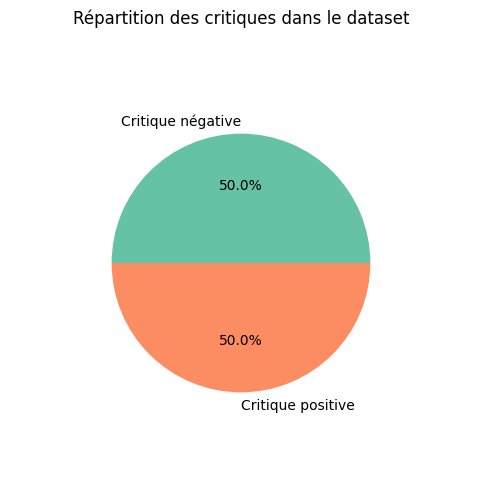

In [11]:
import matplotlib.pyplot as plt

# Calculer les proportions des différentes classes
label_counts = df['label'].value_counts()
# Créer un diagramme circulaire
plt.figure(figsize=(6, 6))
plt.pie(label_counts.values, labels=['Critique négative', 'Critique positive'], autopct='%1.1f%%', colors=['#66c2a5', '#fc8d62'], radius=0.7)
plt.title('Répartition des critiques dans le dataset')
plt.show()


Ce pipeline effectue les étapes de prétraitement suivantes :

Conversion en minuscules
Suppression de la ponctuation
Suppression des chiffres
Tokenization
Suppression des mots vides et des mots courts
Lemmatization avec utilisation de stemmer

In [12]:
from bs4 import BeautifulSoup
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

import nltk
nltk.download('stopwords')
nltk.download('punkt')

class TextPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('french'))
        self.stemmer = SnowballStemmer('french')

    def preprocess_text(self, text):
        # Convertir en minuscules
        text = text.lower()
         # Supprimer les liens hypertextes
        text = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", " ", text)
        # Supprimer les balises HTML
        text = BeautifulSoup(text, "lxml").get_text()
        # Remplacer les caractères autres que des lettres par des espaces
        text = re.sub("[^a-zA-Z]", " ", text)
        # Supprimer la ponctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Supprimer les chiffres
        text = re.sub(r'\d+', '', text)
        # Tokenization
        tokens = word_tokenize(text, language='french')
        # Supprimer les mots vides et les mots courts
        tokens = [word for word in tokens if word not in self.stop_words and len(word) > 2]
        # Lemmatization
        tokens = [self.stemmer.stem(word) for word in tokens]
        # Rejoindre les tokens en une chaîne de texte
        preprocessed_text = ' '.join(tokens)
        return preprocessed_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [13]:
# Créer une instance de TextPreprocessor
preprocessor = TextPreprocessor()

# Appliquer la prétraitement sur la colonne 'review' du DataFrame
df['preprocessed_review'] = df['review'].apply(preprocessor.preprocess_text)

In [14]:
df.head()

,review,label,preprocessed_review
0,Si vous cherchez du cinéma abrutissant à tous ...,0,cherch cin abrut tous tag aucun peur clich cas...
1,"Trash, re-trash et re-re-trash...! Une horreur...",0,trash trash trash horreur san nom imagin prem ...
2,"Et si, dans les 5 premières minutes du film, l...",0,prem re minut film path tiqu maquet train fend...
3,Mon dieu ! Quelle métaphore filée ! Je suis ab...,0,dieu quel taphor fil abasourd ellement ici tap...
4,"Premier film de la saga Kozure Okami, ""Le Sabr...",1,premi film sag kozur okam sabr vengeanc bon fi...


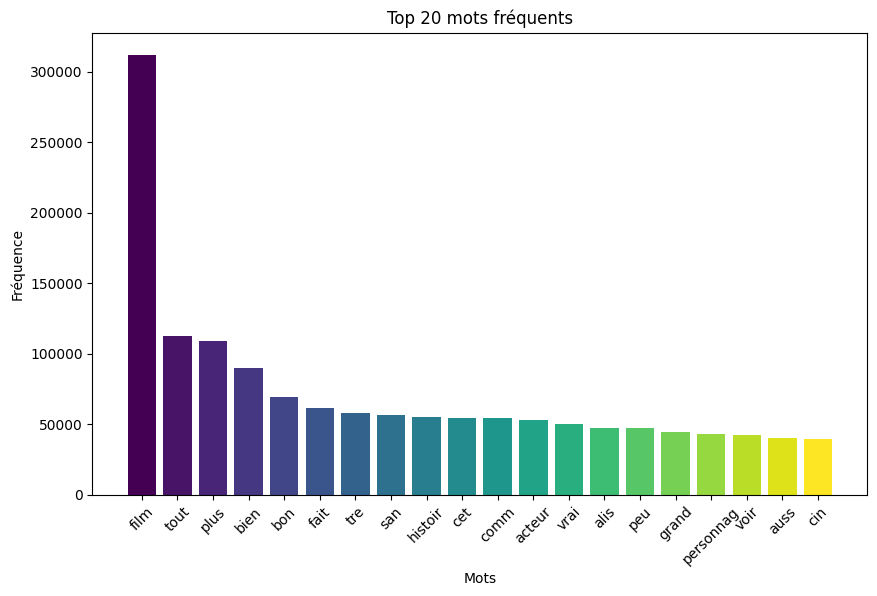

In [15]:
import nltk
import numpy as np
all_words = ' '.join(df['preprocessed_review']).split()
# Calcul de la fréquence des mots
word_freq = nltk.FreqDist(all_words)

# Récupération des 20 mots les plus fréquents
top_words = word_freq.most_common(20)
words, frequencies = zip(*top_words)
colors = plt.cm.viridis(np.linspace(0, 1, len(words)))


plt.figure(figsize=(10,6))
for word, frequency, color in zip(words, frequencies, colors):
    plt.bar(word, frequency, color=color)

plt.title('Top 20 mots fréquents')
plt.xlabel('Mots')
plt.ylabel('Fréquence')
plt.xticks(rotation=45)
plt.show()


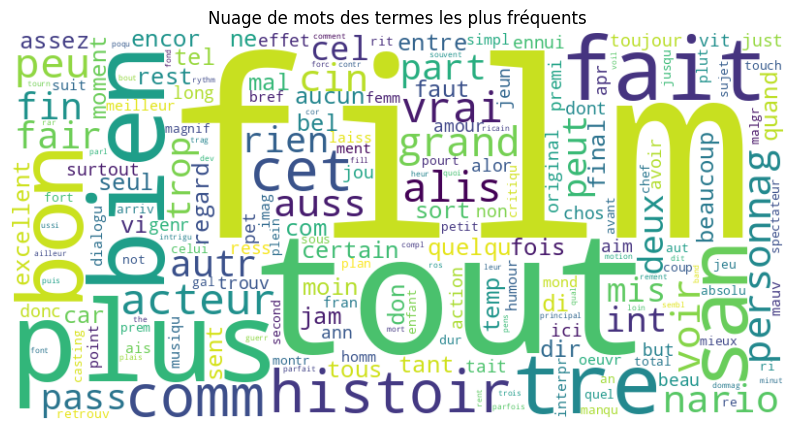

In [16]:
from wordcloud import WordCloud
# Créer un objet WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Afficher le nuage de mots
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuage de mots des termes les plus fréquents')
plt.show()


### III) Définition des ensembles d’entraînement, de validation et de test

#### LogisticRegression (TD-IDF)
model: tfidf_clf

best model :best_clf

In [17]:
# Echantillonnage d'un pourcentage des données train, validation et test
t=0.6
dataset['train']=dataset['train'][:int(len(dataset['train']) * t)]
dataset['validation']=dataset['validation'][:int(len(dataset['validation']) * t)]
dataset['test']=dataset['test'][:int(len(dataset['test']) * t)]

In [18]:
X_train, y_train = np.array(dataset['train']['review']), np.array(dataset['train']['label'])
X_val, y_val = np.array(dataset['validation']['review']), np.array(dataset['validation']['label'])
X_test, y_test = np.array(dataset['test']['review']), np.array(dataset['test']['label'])

print("LEN TRAIN: "+ str(len(X_train)))
print("LEN VAL: "+ str(len(X_val)))
print("LEN TEST: "+ str(len(X_test)))

LEN TRAIN: 96000
LEN VAL: 12000
LEN TEST: 12000


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')

tfidf_clf = Pipeline([
    ('tfidf', TfidfVectorizer()), # Default parameters
    ('clf', LogisticRegression(n_jobs=-1, verbose=1)),
])

tfidf_clf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', LogisticRegression(n_jobs=-1, verbose=1))])

### Prediction

In [20]:
some_index = 0
some_review = X_val[some_index]
print(some_review)
print()
print("Label:", y_val[some_index])

Ce film est tout ce qu'il y a de plus sympa. Même si l'ensemble n'est pas dépourvu de clichés, il serait hypocrite de dire que ce film est ennuyeux à regarder, bien au contraire. Il est très plaisant à regarder et même si l'ensemble est asse convenue, la mise en scène de Peter Chelsom est légère et ce film est une sorte de bouffée d'air frais. Tout à fait estimable.

Label: 0


In [21]:
some_prediction = tfidf_clf.predict([some_review, ])
print("Label:", some_prediction[0]) # Good prediction !

Label: 0


In [22]:
from sklearn import metrics

# Predicting training dataset
y_pred = tfidf_clf.predict(X_train)
print("Training Accuracy:", metrics.accuracy_score(y_train, y_pred))

# Predicting with a test dataset

y_pred = tfidf_clf.predict(X_val)
print("Validation Accuracy:", metrics.accuracy_score(y_val, y_pred))
print()
print(metrics.classification_report(y_val, y_pred))

Training Accuracy: 0.9408020833333334
Validation Accuracy: 0.9195

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      6169
           1       0.91      0.93      0.92      5831

    accuracy                           0.92     12000
   macro avg       0.92      0.92      0.92     12000
weighted avg       0.92      0.92      0.92     12000



### Grid Search

In [23]:
from sklearn.model_selection import PredefinedSplit

# Grid-search on validation set.
X = np.concatenate((X_train, X_val), axis=0)
y = np.concatenate((y_train, y_val), axis=0)
validation_indexes = [-1]*len(X_train) + [0]*len(X_val)
ps = PredefinedSplit(test_fold=validation_indexes)

In [24]:
from sklearn.model_selection import GridSearchCV

param_grid = {
     'tfidf__lowercase': (True, False),
     'tfidf__ngram_range': [(1, 1), (1, 2)],
     'tfidf__max_df': [ 0.65, 0.70, 0.75],
     'clf__C': np.logspace(-4, 4, 5),
}

tfidf_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(penalty='l2', n_jobs=-1, verbose=1)),
])

grid_search = GridSearchCV(
    tfidf_clf, param_grid, cv=ps,
    scoring='accuracy', return_train_score=True,
    n_jobs=-1, verbose=1
)

grid_search.fit(X, y)

Fitting 1 folds for each of 60 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf',
                                        LogisticRegression(n_jobs=-1,
                                                           verbose=1))]),
             n_jobs=-1,
             param_grid={'clf__C': array([1.e-04, 1.e-02, 1.e+00, 1.e+02, 1.e+04]),
                         'tfidf__lowercase': (True, False),
                         'tfidf__max_df': [0.65, 0.7, 0.75],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [25]:
print(grid_search.best_params_) # print ?
print(grid_search.best_score_)

best_clf = grid_search.best_estimator_

{'clf__C': 100.0, 'tfidf__lowercase': False, 'tfidf__max_df': 0.7, 'tfidf__ngram_range': (1, 2)}
0.9410833333333334


### Training best model

In [26]:
best_clf = Pipeline([
    ('tfidf', TfidfVectorizer(
        lowercase=True, ngram_range=(1, 2),
        max_df=0.65
    )),
    ('clf', LogisticRegression(
        C=100, penalty='l2',
        n_jobs=-1, verbose=1
    )),
])

best_clf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.65, ngram_range=(1, 2))),
                ('clf', LogisticRegression(C=100, n_jobs=-1, verbose=1))])

### Results

In [27]:
from sklearn import metrics

y_pred = best_clf.predict(X_val)

print("Val Accuracy: {:.2f}".format(100 * metrics.accuracy_score(y_val, y_pred)))
print("Val F1-Score: {:.2f}".format(100 * metrics.f1_score(y_val, y_pred)))
print()

report = metrics.classification_report(
    y_val, y_pred
)
print(report)

Val Accuracy: 94.04
Val F1-Score: 93.94

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      6169
           1       0.93      0.95      0.94      5831

    accuracy                           0.94     12000
   macro avg       0.94      0.94      0.94     12000
weighted avg       0.94      0.94      0.94     12000



### Learning curves

In [28]:
from sklearn.model_selection import learning_curve

# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(
    best_clf, X, y, cv=ps,
    scoring='accuracy',n_jobs=-1,verbose=1,
    # 10 different sizes of the training set
    train_sizes=np.linspace(0.01, 1.0, 10)
)

[learning_curve] Training set sizes: [  960 11520 22080 32640 43200 53760 64320 74880 85440 96000]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.9min finished


In [29]:
#import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

def plot_learning_curves(train_sizes, train_scores, test_scores, figsize=(10,7), fontsize=14):
    # Create means and standard deviations of training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Create means and standard deviations of test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    fig = plt.figure(figsize=figsize)

    # Draw lines
    plt.plot(train_sizes, train_mean, '--', color="r",  label="Training score")
    plt.plot(train_sizes, test_mean, color="g", label="Validation score")

    # Draw bands
    #plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    #plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

    # Create plot
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy Score")
    plt.legend(loc="lower right")


    return fig

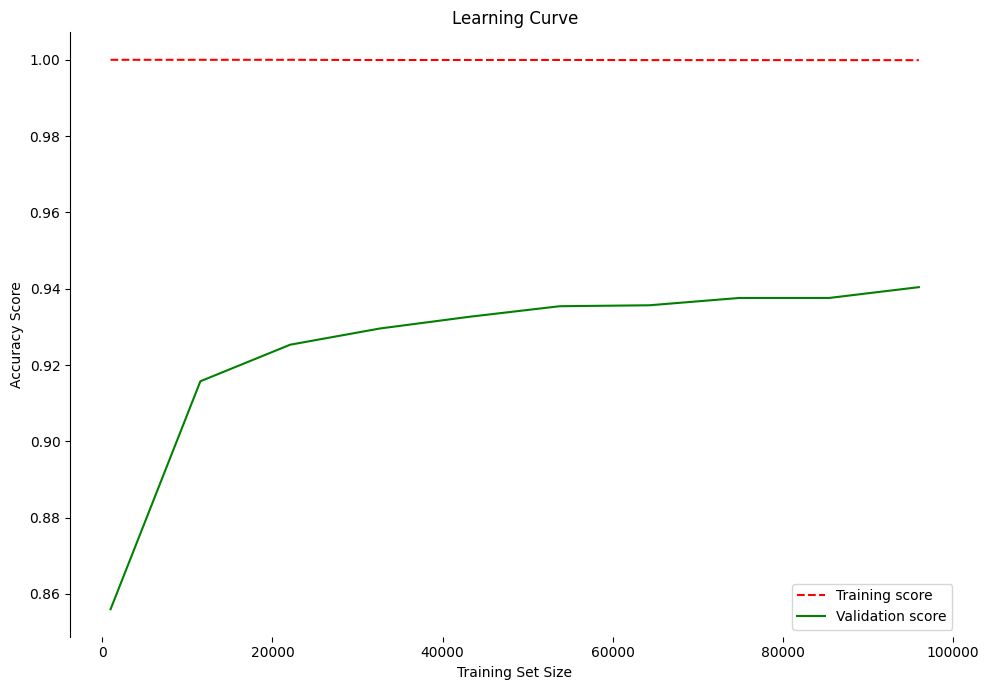

In [30]:
import seaborn as sns

fig = plot_learning_curves(train_sizes, train_scores, test_scores)

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

### Confusion matrix

In [31]:
def plot_training_curves(history, figsize=(12, 5)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Val'], loc='upper left')

    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Val'], loc='upper left')

    return fig


def print_confusion_matrix(confusion_matrix,  figsize=(10, 7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix
    )
    fig = plt.figure(figsize=figsize)

    heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
    heatmap.yaxis.set_ticklabels(
        heatmap.yaxis.get_ticklabels(), rotation=0,
        ha='right', fontsize=fontsize
    )
    heatmap.xaxis.set_ticklabels(
        heatmap.xaxis.get_ticklabels(), rotation=45,
        ha='right', fontsize=fontsize
    )

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

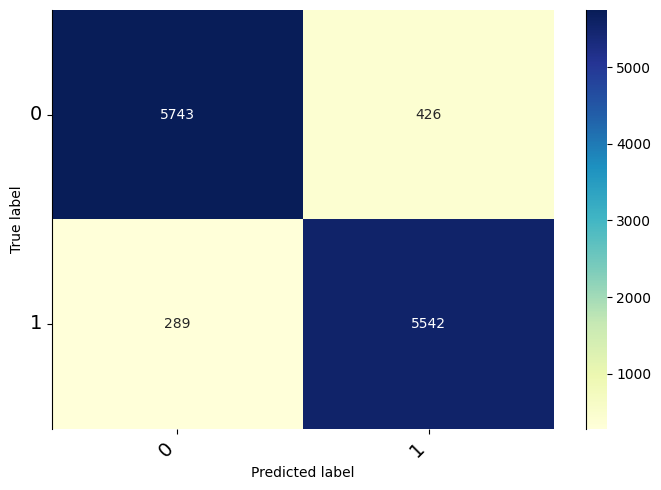

In [32]:
from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(y_val, y_pred)

fig = print_confusion_matrix(
    conf_mx,
    figsize=(7,5)
)

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

### word vectors
Tokenize

We train the tokenizer on the reviews of the train set


In [33]:
# Reviews need to be tokenized
train_reviews = np.array(dataset['train']['review'])
val_reviews = np.array(dataset['validation']['review'])
test_reviews = np.array(dataset['test']['review'])

# Used to train fit tokenizer
#all_reviews = np.concatenate((train_reviews, val_reviews, test_reviews), axis=0)

train_labels = dataset['train']['label']
val_labels = dataset['validation']['label']
test_labels = dataset['test']['label']

In [34]:
import tensorflow as tf
MAX_NB_WORDS = 2000

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=MAX_NB_WORDS,
    oov_token="<unk>",
)
tokenizer.fit_on_texts(train_reviews)

word_index = tokenizer.word_index
print("Found {} unique tokens.".format(len(word_index)))

Found 146832 unique tokens.


In [35]:
train_reviews_tokenized = tokenizer.texts_to_sequences(train_reviews)
val_reviews_tokenized = tokenizer.texts_to_sequences(val_reviews)
test_reviews_tokenized = tokenizer.texts_to_sequences(test_reviews)

In [36]:
some_review = train_reviews_tokenized[0]
some_review[:15]

[45, 68, 1, 17, 77, 1, 7, 80, 9, 1, 1, 257, 431, 17, 1204]

In [37]:
index_to_word = dict((i, w) for w, i in tokenizer.word_index.items())
" ".join([index_to_word[i] for i in some_review[:15]])

'si vous <unk> du cinéma <unk> à tous les <unk> <unk> aucune peur du cliché'

Average length: 91.2
Max length: 389


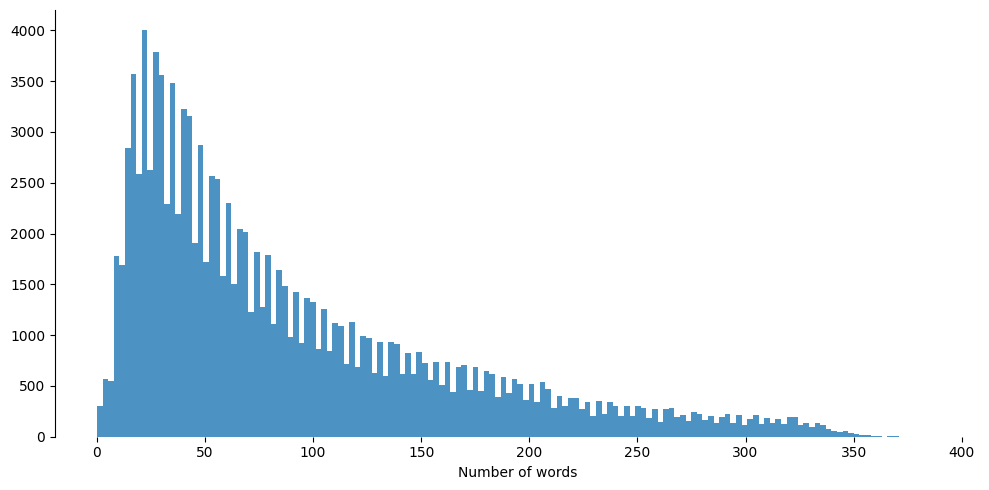

In [38]:
reviews_len = [len(s) for s in train_reviews_tokenized+val_reviews_tokenized+test_reviews_tokenized]
print("Average length: {:.1f}".format(np.mean(reviews_len)))
print("Max length: {}".format(max(reviews_len)))

plt.figure(figsize=(10,5))
ax = sns.distplot(reviews_len, bins=150, kde=False, hist_kws=dict(alpha=0.8))
ax.set(xlabel='Number of words')

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

In [39]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_LENGTH_SEQ = 350 #

X_train = pad_sequences(
    train_reviews_tokenized,
    maxlen=MAX_LENGTH_SEQ,
    padding='post'
)

X_val = pad_sequences(
    val_reviews_tokenized,
    maxlen=MAX_LENGTH_SEQ,
    padding='post'
)

X_test = pad_sequences(
    test_reviews_tokenized,
    maxlen=MAX_LENGTH_SEQ,
    padding='post'
)

print('Shape of X_train tensor:', X_train.shape)
print('Shape of X_val tensor:', X_val.shape)
print('Shape of X_test tensor:', X_test.shape)

Shape of X_train tensor: (96000, 350)
Shape of X_val tensor: (12000, 350)
Shape of X_test tensor: (12000, 350)


### Preprocessing pipeline

In order to carry out the preprocessing phase more efficiently, we can define a Scikit-Learn transformer.


In [40]:
from sklearn.base import BaseEstimator, TransformerMixin

class SequencePreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, max_nbr_words, max_seq_length):
        self.tokenizer = tf.keras.preprocessing.text.Tokenizer(
            num_words=max_nbr_words,
            oov_token="<unk>",
        )
        self.max_seq_length = max_seq_length

    # the arguments are ignored anyway, so we make them optional
    def fit(self, X):
        self.tokenizer.fit_on_texts(X)

    def transform(self, X, y):
        # 1. Tokenize
        X_tokenized = self.tokenizer.texts_to_sequences(X)
        # 2. Remove empty sequences
        X_not_empty, y_not_empty = remove_empty_sequences(X_tokenized, y)
        # 3. Pad
        X_padded = tf.keras.preprocessing.sequence.pad_sequences(
            X_not_empty,
            maxlen=self.max_seq_length,
            padding='post'
        )
        # 4. labels
        y_array = np.array(y_not_empty)
        return X_padded, y_array

    def fit_transform(self, X, y):
        self.fit(X)
        return self.transform(X, y)

### fastText
### Model: model_Fast

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense

# Hyperparameters
max_features = MAX_NB_WORDS
embedding_dim = 128

model_Fast = Sequential(name='fasttext')
model_Fast.add(Embedding(max_features, embedding_dim,
                           input_shape=[None]),)
model_Fast.add(GlobalAveragePooling1D())
model_Fast.add(Dense(1, activation="sigmoid"))

model_Fast.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [42]:
initial_weights = model_Fast.get_weights()
model_Fast.summary()

Model: "fasttext"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         256000    
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 256129 (1000.50 KB)
Trainable params: 256129 (1000.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
history = model_Fast.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10, batch_size=128,
     verbose=1)

Epoch 1/10
750/750 [==============================] - 22s 26ms/step - loss: 0.5668 - accuracy: 0.7579 - val_loss: 0.4203 - val_accuracy: 0.8571
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 0.3593 - accuracy: 0.8722 - val_loss: 0.3097 - val_accuracy: 0.8899
Epoch 3/10
750/750 [==============================] - 3s 4ms/step - loss: 0.2949 - accuracy: 0.8897 - val_loss: 0.2762 - val_accuracy: 0.8964
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 0.2687 - accuracy: 0.8971 - val_loss: 0.2616 - val_accuracy: 0.9020
Epoch 5/10
750/750 [==============================] - 3s 4ms/step - loss: 0.2558 - accuracy: 0.9003 - val_loss: 0.2524 - val_accuracy: 0.9040
Epoch 6/10
750/750 [==============================] - 2s 3ms/step - loss: 0.2487 - accuracy: 0.9031 - val_loss: 0.2487 - val_accuracy: 0.9075
Epoch 7/10
750/750 [==============================] - 2s 3ms/step - loss: 0.2446 - accuracy: 0.9038 - val_loss: 0.2482 - val_accuracy: 0.9074
Epoc

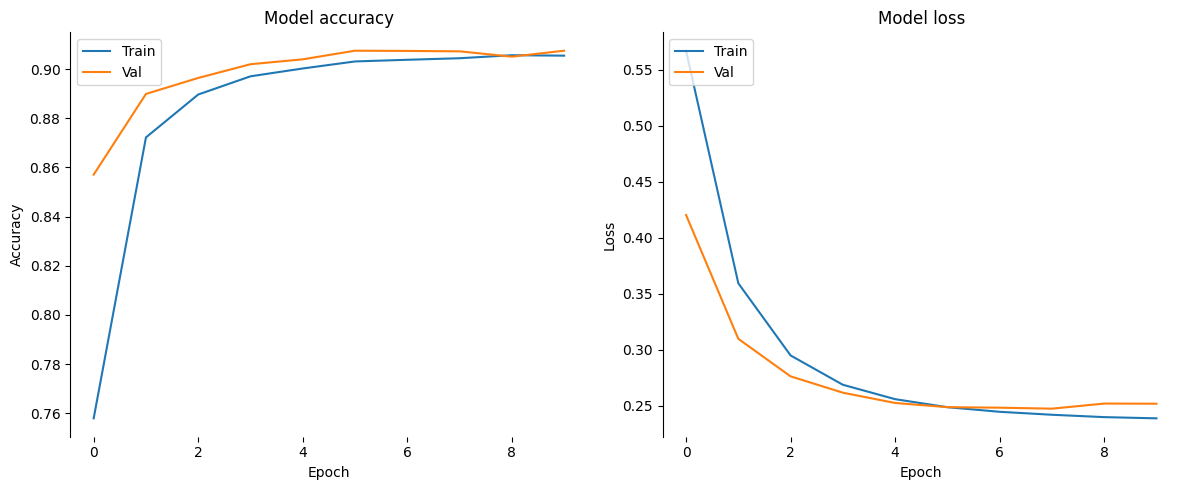

In [44]:
fig = plot_training_curves(history)

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

In [45]:
from sklearn import metrics

probas = model_Fast.predict(X_val)
y_pred = (probas > 0.5).astype(int)

print("Val Accuracy: {:.2f}".format(100 * metrics.accuracy_score(y_val, y_pred)))
print("Val F1-Score: {:.2f}".format(100 * metrics.f1_score(y_val, y_pred)))

375/375 [==============================] - 1s 1ms/step
Val Accuracy: 90.75
Val F1-Score: 90.68


### Testing

In [46]:
probas = model_Fast.predict(X_test)
y_pred = (probas > 0.5).astype(int)

375/375 [==============================] - 0s 1ms/step


In [47]:
print("Test Accuracy: {:.2f}".format(100 * metrics.accuracy_score(y_test, y_pred)))
print("Test F1-Score: {:.2f}".format(100 * metrics.f1_score(y_test, y_pred)))
print()

report = metrics.classification_report(
    y_test, y_pred
)
print(report)

Test Accuracy: 90.22
Test F1-Score: 89.91

              precision    recall  f1-score   support

           0       0.91      0.90      0.91      6247
           1       0.89      0.91      0.90      5753

    accuracy                           0.90     12000
   macro avg       0.90      0.90      0.90     12000
weighted avg       0.90      0.90      0.90     12000



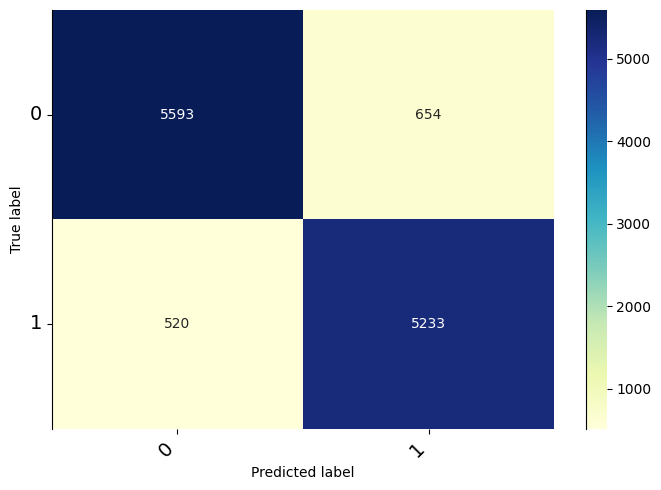

In [48]:
conf_mx = confusion_matrix(y_test, y_pred)

fig = print_confusion_matrix(
    conf_mx,
    figsize=(7,5)
)

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

### RNN
### Model

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense

# Hyperparameters
embedding_dim = 128
hidden_dim = 256

model_RNN = Sequential(name='rnn')
model_RNN.add(Embedding(MAX_NB_WORDS, embedding_dim,
                    mask_zero=True, input_shape=[None]))

model_RNN.add(GRU(hidden_dim, return_sequences=True))
model_RNN.add(GRU(hidden_dim))
model_RNN.add(Dense(1, activation="sigmoid"))

model_RNN.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [50]:
initial_weights = model_RNN.get_weights()
model_RNN.summary()

Model: "rnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         256000    
                                                                 
 gru (GRU)                   (None, None, 256)         296448    
                                                                 
 gru_1 (GRU)                 (None, 256)               394752    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 947457 (3.61 MB)
Trainable params: 947457 (3.61 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [51]:
history_RNN = model_RNN.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5, batch_size=64, verbose=1)

Epoch 1/5
1500/1500 [==============================] - 79s 48ms/step - loss: 0.2797 - accuracy: 0.8800 - val_loss: 0.1946 - val_accuracy: 0.9233
Epoch 2/5
1500/1500 [==============================] - 50s 33ms/step - loss: 0.1968 - accuracy: 0.9206 - val_loss: 0.1907 - val_accuracy: 0.9224
Epoch 3/5
1500/1500 [==============================] - 49s 33ms/step - loss: 0.1723 - accuracy: 0.9307 - val_loss: 0.1779 - val_accuracy: 0.9291
Epoch 4/5
1500/1500 [==============================] - 48s 32ms/step - loss: 0.1549 - accuracy: 0.9389 - val_loss: 0.1758 - val_accuracy: 0.9308
Epoch 5/5
1500/1500 [==============================] - 48s 32ms/step - loss: 0.1365 - accuracy: 0.9468 - val_loss: 0.1896 - val_accuracy: 0.9225


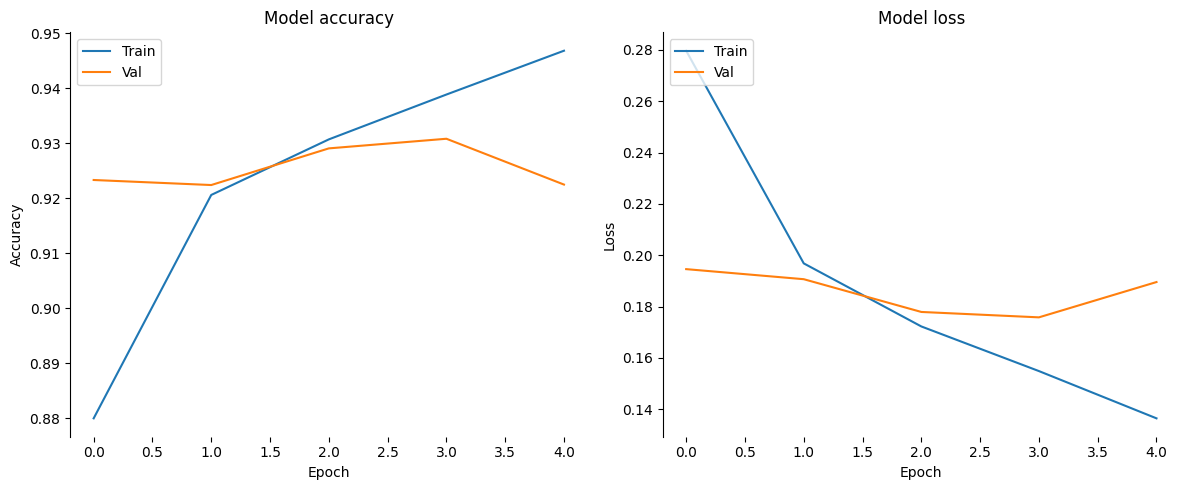

In [52]:
fig = plot_training_curves(history_RNN)

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

In [53]:
from sklearn import metrics

probas = model_RNN.predict(X_val)
y_pred = (probas > 0.5).astype(int)

print("Val Accuracy: {:.2f}".format(100 * metrics.accuracy_score(y_val, y_pred)))
print("Val F1-Score: {:.2f}".format(100 * metrics.f1_score(y_val, y_pred)))

375/375 [==============================] - 5s 10ms/step
Val Accuracy: 92.25
Val F1-Score: 92.31


### Testing

In [54]:
probas = model_RNN.predict(X_test)
y_pred = (probas > 0.5).astype(int)

375/375 [==============================] - 4s 10ms/step


In [55]:
print("Test Accuracy: {:.2f}".format(100 * metrics.accuracy_score(y_test, y_pred)))
print("Test F1-Score: {:.2f}".format(100 * metrics.f1_score(y_test, y_pred)))
print()

report = metrics.classification_report(
    y_test, y_pred
)
print(report)

Test Accuracy: 92.12
Test F1-Score: 92.04

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      6247
           1       0.89      0.95      0.92      5753

    accuracy                           0.92     12000
   macro avg       0.92      0.92      0.92     12000
weighted avg       0.92      0.92      0.92     12000



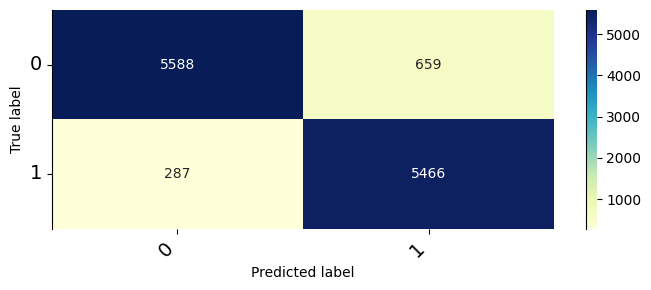

In [56]:
conf_mx = confusion_matrix(y_test, y_pred)

fig = print_confusion_matrix(
    conf_mx,
    figsize=(7,3)
)

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)


### CNN
### Model

In [57]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Embedding, Conv1D, GlobalMaxPooling1D,
                                     BatchNormalization, Dropout, Dense)
from tensorflow.keras.layers import concatenate

# Hyperparameters
embedding_dim = 512
hidden_dim = 512
dropout_rate = 0.05

input_layer = tf.keras.layers.Input(shape=(MAX_LENGTH_SEQ,), dtype=tf.int32)

layer = Embedding(MAX_NB_WORDS, output_dim=embedding_dim)(input_layer)

layer_conv3 = Conv1D(hidden_dim, 3, activation="relu")(layer)
layer_conv3 = GlobalMaxPooling1D()(layer_conv3)

layer_conv4 = Conv1D(hidden_dim, 2, activation="relu")(layer)
layer_conv4 = GlobalMaxPooling1D()(layer_conv4)

layer = concatenate([layer_conv4, layer_conv3], axis=1)
layer = BatchNormalization()(layer)
layer = Dropout(dropout_rate)(layer)

output = Dense(1, activation="sigmoid")(layer)

model_CNN = Model(name='cnn', inputs=[input_layer], outputs=output)

model_CNN.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [58]:
initial_weights = model_CNN.get_weights()
model_CNN.summary()

Model: "cnn"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 350)]                0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 350, 512)             1024000   ['input_1[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, 349, 512)             524800    ['embedding_2[0][0]']         
                                                                                                  
 conv1d (Conv1D)             (None, 348, 512)             786944    ['embedding_2[0][0]']         
                                                                                                

In [59]:
history_CNN = model_CNN.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5, batch_size=128,
     verbose=1)

Epoch 1/5
750/750 [==============================] - 31s 35ms/step - loss: 0.2449 - accuracy: 0.8973 - val_loss: 0.2035 - val_accuracy: 0.9177
Epoch 2/5
750/750 [==============================] - 12s 16ms/step - loss: 0.1512 - accuracy: 0.9417 - val_loss: 0.2015 - val_accuracy: 0.9182
Epoch 3/5
750/750 [==============================] - 10s 13ms/step - loss: 0.1018 - accuracy: 0.9621 - val_loss: 0.2116 - val_accuracy: 0.9228
Epoch 4/5
750/750 [==============================] - 10s 14ms/step - loss: 0.0682 - accuracy: 0.9752 - val_loss: 0.2480 - val_accuracy: 0.9186
Epoch 5/5
750/750 [==============================] - 10s 14ms/step - loss: 0.0486 - accuracy: 0.9825 - val_loss: 0.2868 - val_accuracy: 0.9128


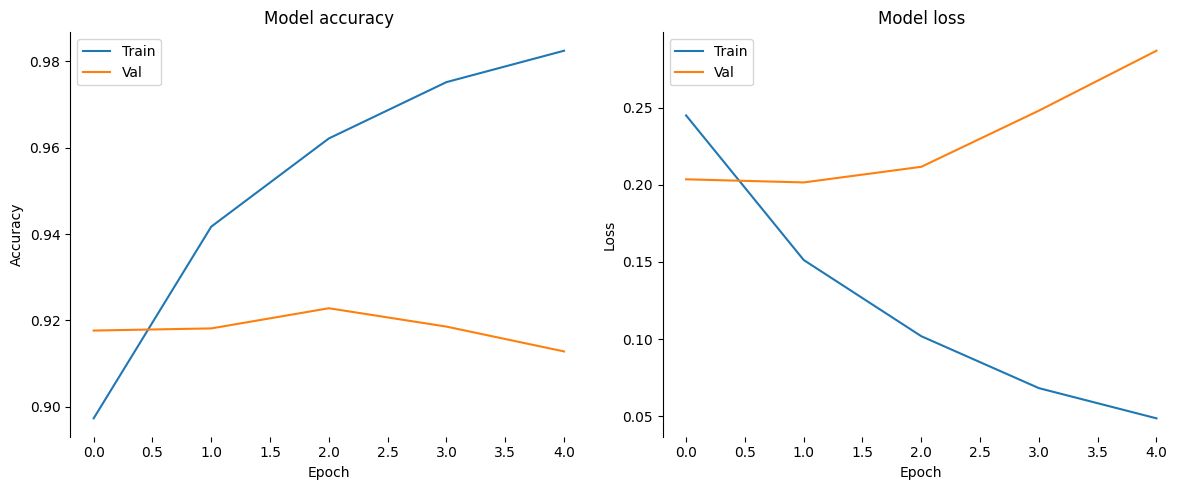

In [60]:
fig = plot_training_curves(history_CNN)

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

In [61]:
probas = model_CNN.predict(X_val)
y_pred = (probas > 0.5).astype(int)

print("Val Accuracy: {:.2f}".format(100 * metrics.accuracy_score(y_val, y_pred)))
print("Val F1-Score: {:.2f}".format(100 * metrics.f1_score(y_val, y_pred)))

375/375 [==============================] - 1s 2ms/step
Val Accuracy: 91.28
Val F1-Score: 90.62


In [62]:
probas = model_CNN.predict(X_test)
y_pred = (probas > 0.5).astype(int)

375/375 [==============================] - 1s 2ms/step


In [63]:
print("Test Accuracy: {:.2f}".format(100 * metrics.accuracy_score(y_test, y_pred)))
print("Test F1-Score: {:.2f}".format(100 * metrics.f1_score(y_test, y_pred)))
print()

report = metrics.classification_report(
    y_test, y_pred,
)
print(report)

Test Accuracy: 90.72
Test F1-Score: 89.79

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      6247
           1       0.95      0.85      0.90      5753

    accuracy                           0.91     12000
   macro avg       0.91      0.90      0.91     12000
weighted avg       0.91      0.91      0.91     12000



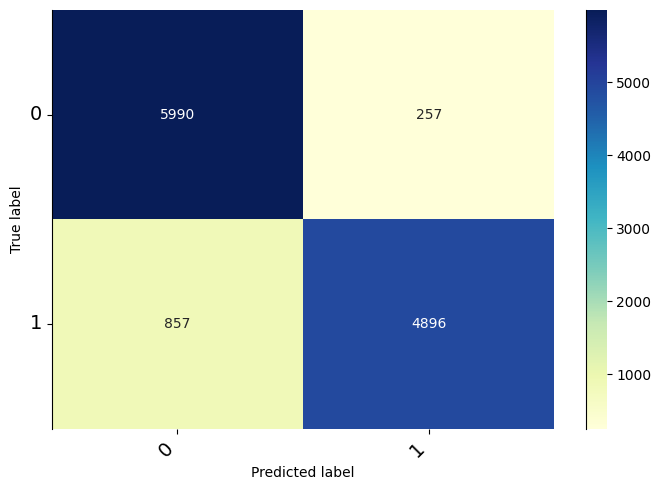

In [64]:

conf_mx = confusion_matrix(y_test, y_pred)

fig = print_confusion_matrix(
    conf_mx,
    figsize=(7,5)
)

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

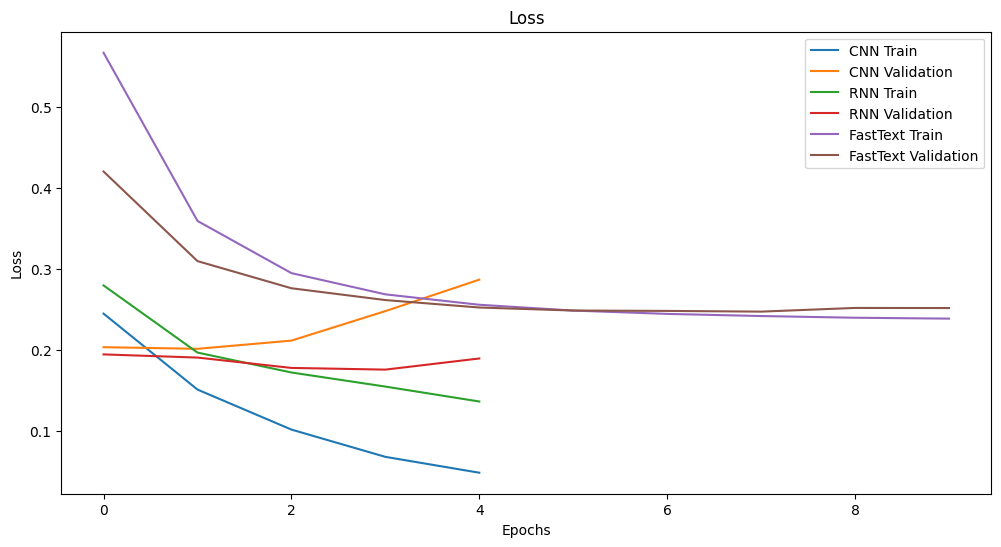

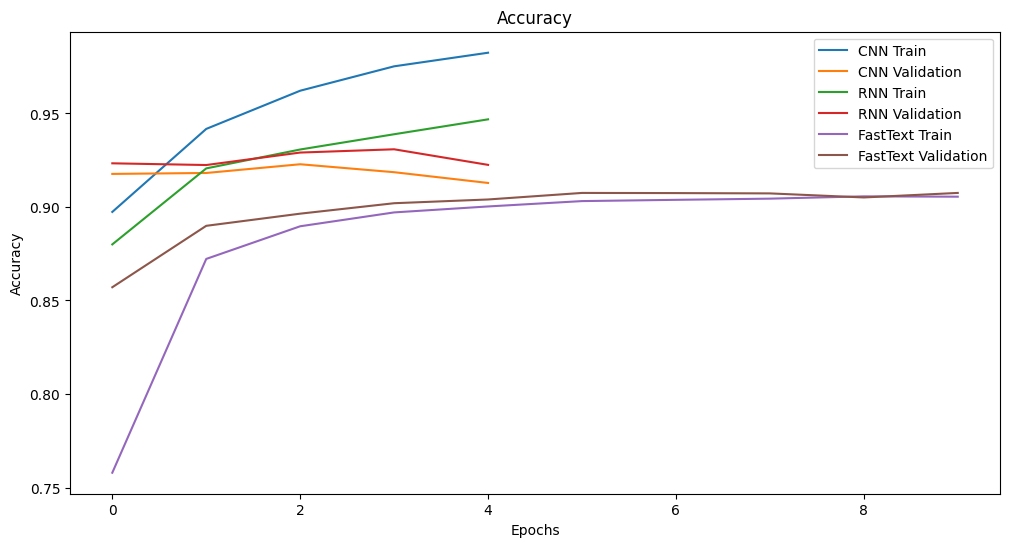

In [70]:
# Collecter les métriques pour FastText
loss_fasttext = history.history['loss']
val_loss_fasttext = history.history['val_loss']
acc_fasttext = history.history['accuracy']
val_acc_fasttext = history.history['val_accuracy']

# Tracer les courbes de perte avec marqueurs
plt.figure(figsize=(12, 6))
plt.plot(loss_CNN, label='CNN Train', marker='x')
plt.plot(val_loss_CNN, label='CNN Validation', marker='^')
plt.plot(loss_RNN, label='RNN Train', marker='o')
plt.plot(val_loss_RNN, label='RNN Validation', marker='s')
plt.plot(loss_fasttext, label='FastText Train', marker='d')  # Ajouter la perte d'entraînement pour FastText
plt.plot(val_loss_fasttext, label='FastText Validation', marker='p')  # Ajouter la perte de validation pour FastText
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Tracer les courbes de précision avec marqueurs
plt.figure(figsize=(12, 6))
plt.plot(acc_CNN, label='CNN Train', marker='x')
plt.plot(val_acc_CNN, label='CNN Validation', marker='^')
plt.plot(acc_RNN, label='RNN Train', marker='o')
plt.plot(val_acc_RNN, label='RNN Validation', marker='s')
plt.plot(acc_fasttext, label='FastText Train', marker='d')  # Ajouter la précision d'entraînement pour FastText
plt.plot(val_acc_fasttext, label='FastText Validation', marker='p')  # Ajouter la précision de validation pour FastText
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


### IV) Prétraitement des données

In [6]:
# Echantillonnage d'un pourcentage des données train, validation et test
t=0.5
dataset['train']=dataset['train'][:int(len(dataset['train']) * t)]
dataset['validation']=dataset['validation'][:int(len(dataset['validation']) * t)]
dataset['test']=dataset['test'][:int(len(dataset['test']) * t)]

In [7]:
import numpy as np
X_train, y_train = np.array(dataset['train']['review']), np.array(dataset['train']['label'])
X_val, y_val = np.array(dataset['validation']['review']), np.array(dataset['validation']['label'])
X_test, y_test = np.array(dataset['test']['review']), np.array(dataset['test']['label'])

print("LEN TRAIN: "+ str(len(X_train)))
print("LEN VAL: "+ str(len(X_val)))
print("LEN TEST: "+ str(len(X_test)))

LEN TRAIN: 8000
LEN VAL: 1000
LEN TEST: 1000


In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Vectorisation avec Bag-of-Words
bow_vectorizer = CountVectorizer()
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_val_bow = bow_vectorizer.transform(X_val)
X_test_bow = bow_vectorizer.transform(X_test)

# Vectorisation avec TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initialiser les modèles de classification
nb_classifier = MultinomialNB()
svm_classifier = SVC()

# Entraînement des modèles
nb_classifier.fit(X_train_bow, y_train)
svm_classifier.fit(X_train_tfidf, y_train)

# Prédiction sur les ensembles de validation
nb_val_preds = nb_classifier.predict(X_val_bow)
svm_val_preds = svm_classifier.predict(X_val_tfidf)

# Prédiction sur les ensembles de test
nb_test_preds = nb_classifier.predict(X_test_bow)
svm_test_preds = svm_classifier.predict(X_test_tfidf)

# Évaluation des performances
print("Naive Bayes (BoW) Accuracy on Validation Set:", accuracy_score(y_val, nb_val_preds))
print("Naive Bayes (TF-IDF) Accuracy on Validation Set:", accuracy_score(y_val, svm_val_preds))

print("SVM (BoW) Accuracy on Validation Set:", accuracy_score(y_val, nb_test_preds))
print("SVM (TF-IDF) Accuracy on Validation Set:", accuracy_score(y_val, svm_test_preds))


Naive Bayes (BoW) Accuracy on Validation Set: 0.892
Naive Bayes (TF-IDF) Accuracy on Validation Set: 0.9
SVM (BoW) Accuracy on Validation Set: 0.501
SVM (TF-IDF) Accuracy on Validation Set: 0.494


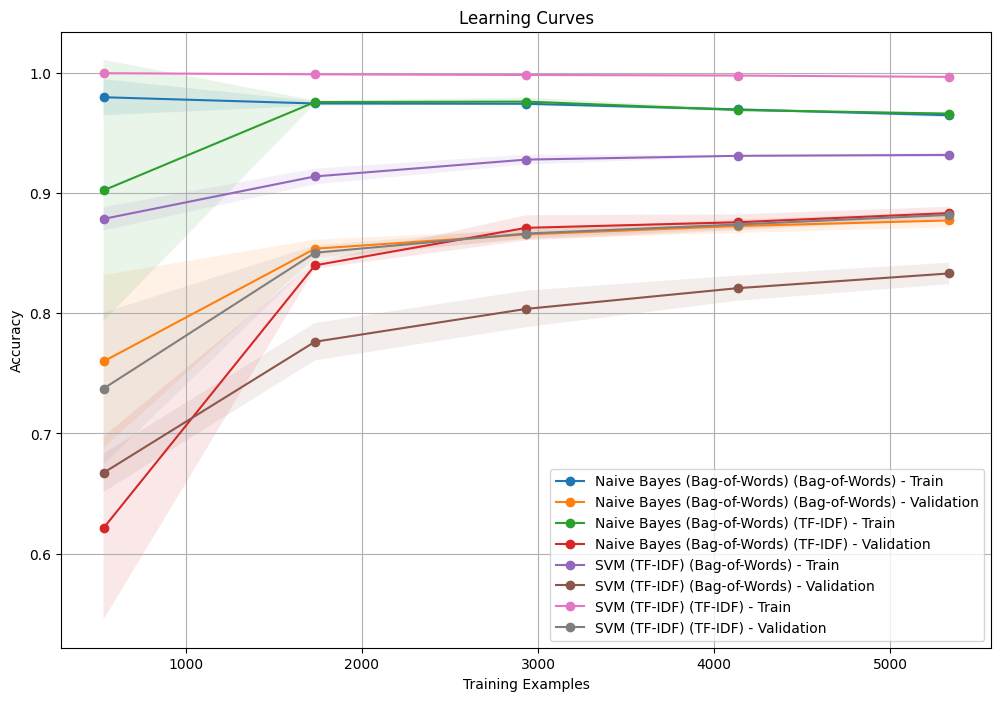

In [9]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Définir les modèles
models = {
    "Naive Bayes (Bag-of-Words)": nb_classifier,
    "SVM (TF-IDF)": svm_classifier
}

# Définir les ensembles de données et les modèles correspondants
datasets = {
    "Bag-of-Words": (X_train_bow, y_train, X_val_bow, y_val),
    "TF-IDF": (X_train_tfidf, y_train, X_val_tfidf, y_val)
}

# Plot learning curve for each model and each dataset
plt.figure(figsize=(12, 8))
for model_name, model in models.items():
    for dataset_name, (X_train, y_train, X_val, y_val) in datasets.items():
        train_sizes, train_scores, valid_scores = learning_curve(
            model, X_train, y_train, cv=3, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 5))
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        valid_scores_mean = np.mean(valid_scores, axis=1)
        valid_scores_std = np.std(valid_scores, axis=1)

        plt.plot(train_sizes, train_scores_mean, label=f"{model_name} ({dataset_name}) - Train", marker='o')
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1)

        plt.plot(train_sizes, valid_scores_mean, label=f"{model_name} ({dataset_name}) - Validation", marker='o')
        plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                         valid_scores_mean + valid_scores_std, alpha=0.1)

plt.title("Learning Curves")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()


# LSTM

In [10]:
pip install gensim

In [11]:
import gensim.downloader as api
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Charger le modèle FastText
model_name = "fasttext-wiki-news-subwords-300"
model = api.load(model_name)

# Encoder les textes avec FastText
def encode_text_with_fasttext(texts, model, max_length):
    encoded_texts = []
    for text in texts:
        if isinstance(text, str):  # Vérifier si le texte est une chaîne de caractères
            encoded_text = []
            for word in text.split():
                if word in model:
                    encoded_text.append(model[word])
            encoded_texts.append(encoded_text)
    return pad_sequences(encoded_texts, maxlen=max_length, dtype='float32')




[==================================================] 100.0% 958.5/958.4MB downloaded


In [12]:
max_length = 50  # Longueur maximale des séquences de mots
X_train_encoded = encode_text_with_fasttext(X_train, model, max_length)
X_val_encoded = encode_text_with_fasttext(X_val, model, max_length)
X_test_encoded = encode_text_with_fasttext(X_test, model, max_length)

Epoch 1/5
125/125 [==============================] - 39s 283ms/step - loss: 0.6876 - accuracy: 0.5274 - val_loss: 0.6694 - val_accuracy: 0.6080
Epoch 2/5
125/125 [==============================] - 27s 216ms/step - loss: 0.5172 - accuracy: 0.7552 - val_loss: 0.4452 - val_accuracy: 0.7900
Epoch 3/5
125/125 [==============================] - 26s 203ms/step - loss: 0.1298 - accuracy: 0.9615 - val_loss: 0.5267 - val_accuracy: 0.7570
Epoch 4/5
125/125 [==============================] - 23s 183ms/step - loss: 0.0126 - accuracy: 0.9980 - val_loss: 0.6251 - val_accuracy: 0.7480
Epoch 5/5
32/32 [==============================] - 1s 30ms/step
LSTM Model - Validation:
Accuracy: 0.778
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.88      0.81       528
           1       0.83      0.67      0.74       472

    accuracy                           0.78      1000
   macro avg       0.79      0.77      0.77      1000
weighted avg       0.79 

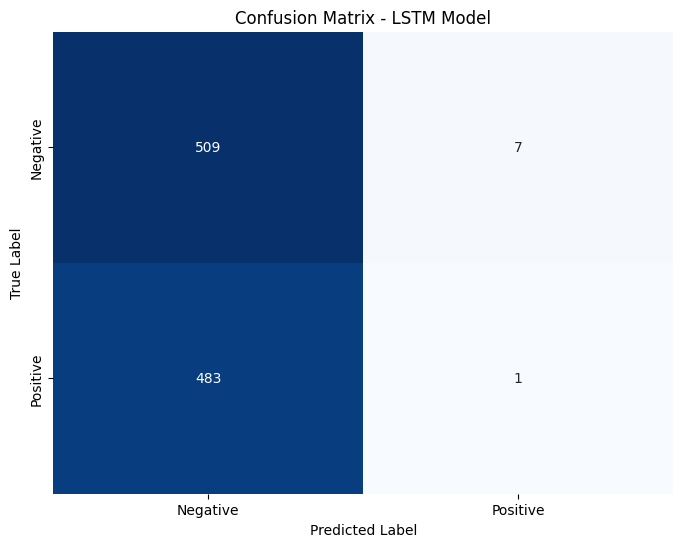

In [15]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Convertir la matrice CSR en une liste de textes
X_train_texts = [str(row) for row in X_train]
X_val_texts = [str(row) for row in X_val]
X_test_texts = [str(row) for row in X_test]

# Tokenize the text and convert them to sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_texts)
word_index = tokenizer.word_index
X_train_encoded = tokenizer.texts_to_sequences(X_train_texts)
X_val_encoded = tokenizer.texts_to_sequences(X_val_texts)
X_test_encoded = tokenizer.texts_to_sequences(X_test_texts)

# Pad sequences to ensure uniform length
max_length = 100  # choose an appropriate length
X_train_padded = pad_sequences(X_train_encoded, maxlen=max_length, padding='post')
X_val_padded = pad_sequences(X_val_encoded, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_encoded, maxlen=max_length, padding='post')

# Define and train the LSTM model
vocab_size = len(word_index) + 1
embedding_size = 100

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size))
lstm_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

lstm_model.fit(X_train_padded, y_train, epochs=5, batch_size=64, validation_data=(X_val_padded, y_val))

# Evaluate the LSTM model
y_pred_lstm_val = (lstm_model.predict(X_val_padded) > 0.5).astype(int)
y_pred_lstm_test = (lstm_model.predict(X_test_padded) > 0.5).astype(int)

print("LSTM Model - Validation:")
print("Accuracy:", accuracy_score(y_val, y_pred_lstm_val))
print("Classification Report:")
print(classification_report(y_val, y_pred_lstm_val))

print("LSTM Model - Test:")
print("Accuracy:", accuracy_score(y_test, y_pred_lstm_test))
print("Classification Report:")
print(classification_report(y_test, y_pred_lstm_test))

# Confusion matrix for the LSTM model
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_lstm_test), annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix - LSTM Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Epoch 1/3
125/125 [==============================] - 21s 166ms/step - loss: 0.0051 - accuracy: 0.9992 - val_loss: 1.2502 - val_accuracy: 0.7270
Epoch 2/3
125/125 [==============================] - 21s 172ms/step - loss: 0.0014 - accuracy: 0.9999 - val_loss: 1.5152 - val_accuracy: 0.7150
Epoch 3/3
125/125 [==============================] - 21s 169ms/step - loss: 0.0025 - accuracy: 0.9998 - val_loss: 1.4089 - val_accuracy: 0.7170


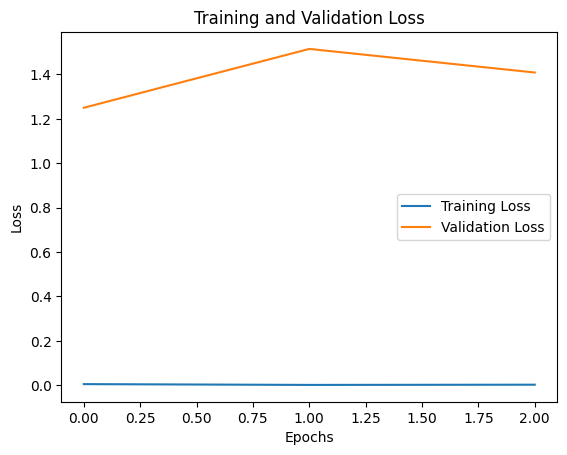

In [18]:
# Train the model and save the training history
history = lstm_model.fit(X_train_padded, y_train, epochs=3, batch_size=64, validation_data=(X_val_padded, y_val))

# Plot training loss and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
